In [17]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

### Import data

In [18]:
## Defined functions

def convert_drugs(value):
    """
    Clean up weird values for drugs text box
    :param value: value to convert
    :return: categegorical value
    """
    if value == "Caffeine (energy drinks/coffee)" or \
        value == "Caffeine (energy drinks/coffee), Kohvi on elu, kohvi on armastus :) " or \
        value == "Herbal tea" or value == 'herbal tea' or value == "tee":
        return "Caffeine"
    elif value.startswith("Ei") or value == "No" or value == "no" or value == "food" or value == "sweets":
        return "No"
    return value

def merge_ids(id, *other_ids):
    for other_id in other_ids:
        common["user_id"].loc[common["user_id"] == other_id] = id
        general["user_id"].loc[general["user_id"] == other_id] = id


In [19]:
## Read data in

general = pd.read_csv("out_general.csv", names=["row", "ts", "user_id", "gender", "age", "prev_test", "pys_activity", "sick", "pain_general", "pain_digest", "sleep_regular"], 
                     usecols=["user_id", "gender", "age", "prev_test", "pys_activity", "sick", "pain_general", "pain_digest", "sleep_regular"], 
                     header=0, 
                     dtype={'gender':'category', 
                            'age':'category', 
                            'prev_test':'category', 
                            'pys_activity':'category', 
                            'sick':'category', 
                            'pain_general':'category', 
                            'pain_digest':'category', 
                            'sleep_regular':'category'
                           })
common = pd.read_csv("out_common.csv", names=["ts", "user_id", "res_number", "res_reaction", "res_visual", "hungry", "sleepy", "time_sleep", "time_wake", "stress",
                                              "fatigue_mental", "fatigue_physical", "drugs"], header=0, 
                     converters={'ts':lambda v: pd.Timestamp(v), 
                                 'time_sleep':lambda v: pd.to_timedelta(v), 
                                 'time_wake':lambda v: pd.to_timedelta(v),
                                 'drugs': convert_drugs},
                     dtype={'hungry':'category', 
                            'sleepy':'category', 
                            'stress':'category', 
                            'fatigue_mental':'category', 
                            'fatigue_physical':'category'})

common["drugs"] = common["drugs"].astype('category')

In [13]:
any(common.user_id == 1)

True

In [20]:
## User related modifications

## Alter user_ids
pd.set_option("mode.chained_assignment", None)

merge_ids(1, 29, 33, 34, 36)
merge_ids(35, 37)
merge_ids(13, 4, 7)
merge_ids(17, 41)
merge_ids(10, 38)

## Delete not suitable users

## Based on user_id

common = common[
    (common["user_id"] != 9) &
    (common["user_id"] != 10) &
    (common["user_id"] != 14) &
    (common["user_id"] != 18) &
    (common["user_id"] != 30) &
    (common["user_id"] != 31)
    ]

## Based on stress levels

common = common[
    (common["stress"] != '4') &
    (common["stress"] != '5')
    ]

## Sick people

sick_subjects_ids = np.array(general.loc[general["sick"] == "Yes", ["user_id"]].values.tolist()).flatten().tolist()

for usr_id in sick_subjects_ids:
    common = common[common["user_id"] != usr_id]

### Add times from waking up

In [68]:
common["stress"].cat.categories

Index(['1', '2', '3', '4', '5'], dtype='object')

In [ ]:
common["drugs"].value_counts()

In [27]:
## Too few rows of hungry level 4 and 5 to draw conclusions 

hungry_level_1 = \
    common.loc[common["hungry"] == '1', ["res_number", "res_reaction", "res_visual"]]
hungry_level_2 = \
    common.loc[common["hungry"] == '2', ["res_number", "res_reaction", "res_visual"]]
hungry_level_3 = \
    common.loc[common["hungry"] == '3', ["res_number", "res_reaction", "res_visual"]]
hungry_level_4 = \
    common.loc[common["hungry"] == '4', ["res_number", "res_reaction", "res_visual"]]
hungry_level_5 = \
    common.loc[common["hungry"] == '5', ["res_number", "res_reaction", "res_visual"]]

grouped_hungry_subjects = \
    common[["user_id", "hungry", "res_number", "res_visual", "res_reaction"]]\
        .groupby(["user_id", "hungry"]).mean()\
        .groupby("hungry").mean()

In [23]:
def draw_bar_plot(plot, title, x_axis_list, y_axis_list):
    plot.set_title(title)

    for i in range(0, len(x_axis_list)):
        plot.bar(x_axis_list[i], y_axis_list[i], align = "center")


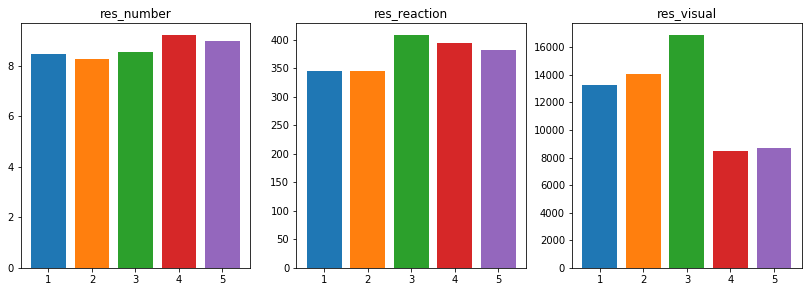

In [28]:
## Average results over all entries

fig, (plt1, plt2, plt3) = plt.subplots(1, 3, figsize = (14, 4.5)) 

draw_bar_plot(plt1, "res_number", ['1', '2', '3', '4', '5'], [
    round(hungry_level_1["res_number"].mean(), 2), 
    round(hungry_level_2["res_number"].mean(), 2),
    round(hungry_level_3["res_number"].mean(), 2),
    round(hungry_level_4["res_number"].mean(), 2),
    round(hungry_level_5["res_number"].mean(), 2)
    ])

draw_bar_plot(plt2, "res_reaction", ['1', '2', '3', '4', '5'], [
    round(hungry_level_1["res_reaction"].mean(), 2), 
    round(hungry_level_2["res_reaction"].mean(), 2),
    round(hungry_level_3["res_reaction"].mean(), 2),
    round(hungry_level_4["res_reaction"].mean(), 2),
    round(hungry_level_5["res_reaction"].mean(), 2)
    ])

draw_bar_plot(plt3, "res_visual", ['1', '2', '3', '4', '5'], [
    round(hungry_level_1["res_visual"].mean(), 2), 
    round(hungry_level_2["res_visual"].mean(), 2),
    round(hungry_level_3["res_visual"].mean(), 2),
    round(hungry_level_4["res_visual"].mean(), 2),
    round(hungry_level_5["res_visual"].mean(), 2)
    ])

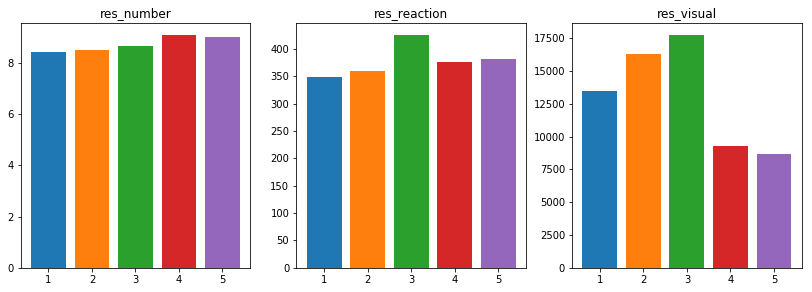

In [29]:
## Average results of averaged subjects results

fig, (plt1, plt2, plt3) = plt.subplots(1, 3, figsize = (14, 4.5)) 

draw_bar_plot(plt1, "res_number", ['1', '2', '3', '4', '5'], [
    grouped_hungry_subjects["res_number"][0], 
    grouped_hungry_subjects["res_number"][1],
    grouped_hungry_subjects["res_number"][2],
    grouped_hungry_subjects["res_number"][3],
    grouped_hungry_subjects["res_number"][4]
    ])

draw_bar_plot(plt2, "res_reaction", ['1', '2', '3', '4', '5'], [
    grouped_hungry_subjects["res_reaction"][0], 
    grouped_hungry_subjects["res_reaction"][1],
    grouped_hungry_subjects["res_reaction"][2],
    grouped_hungry_subjects["res_reaction"][3],
    grouped_hungry_subjects["res_reaction"][4]
    ])

draw_bar_plot(plt3, "res_visual", ['1', '2', '3', '4', '5'], [
    grouped_hungry_subjects["res_visual"][0], 
    grouped_hungry_subjects["res_visual"][1],
    grouped_hungry_subjects["res_visual"][2],
    grouped_hungry_subjects["res_visual"][3],
    grouped_hungry_subjects["res_visual"][4]
    ])

## Add time from wakeup

In [29]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [30]:
ts_wake = common.ts.apply(lambda x: x.replace(hour=0, minute=0, second=0)) + common.time_wake
delta = (common.ts - ts_wake) # TODO minus deltas
common["awake_delta"] = delta  / np.timedelta64(1, 's')

In [31]:
model = ols("res_number ~ awake_delta + hungry + sleepy + stress + fatigue_mental", common).fit()
model.summary()

C:\Users\Kaspar\Miniconda3\lib\site-packages\statsmodels\base\model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\Kaspar\Miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Kaspar\Miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Kaspar\Miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<table class="simpletable">
<caption>OLS Regression Results</caption>
<tr>
  <th>Dep. Variable:</th>       <td>res_number</td>    <th>  R-squared:         </th> <td>   0.031</td>
</tr>
<tr>
  <th>Model:</th>                   <td>OLS</td>       <th>  Adj. R-squared:    </th> <td>  -0.029</td>
</tr>
<tr>
  <th>Method:</th>             <td>Least Squares</td>  <th>  F-statistic:       </th> <td>  0.5149</td>
</tr>
<tr>
  <th>Date:</th>             <td>Thu, 17 Jan 2019</td> <th>  Prob (F-statistic):</th>  <td> 0.904</td> 
</tr>
<tr>
  <th>Time:</th>                 <td>14:36:26</td>     <th>  Log-Likelihood:    </th> <td> -399.66</td>
</tr>
<tr>
  <th>No. Observations:</th>      <td>   209</td>      <th>  AIC:               </th> <td>   825.3</td>
</tr>
<tr>
  <th>Df Residuals:</th>          <td>   196</td>      <th>  BIC:               </th> <td>   868.8</td>
</tr>
<tr>
  <th>Df Model:</th>              <td>    12</td>      <th>                     </th>     <td> </td>   
</tr>
<tr>
  <th>Covariance Type:</th>      <td>nonrobust</td>    <th>                     </th>     <td> </td>   
</tr>
</table>
<table class="simpletable">
<tr>
            <td></td>               <th>coef</th>     <th>std err</th>      <th>t</th>      <th>P>|t|</th>  <th>[0.025</th>    <th>0.975]</th>  
</tr>
<tr>
  <th>Intercept</th>             <td>    8.6261</td> <td>    0.332</td> <td>   25.953</td> <td> 0.000</td> <td>    7.971</td> <td>    9.282</td>
</tr>
<tr>
  <th>hungry[T.2]</th>           <td>   -0.1506</td> <td>    0.310</td> <td>   -0.486</td> <td> 0.627</td> <td>   -0.761</td> <td>    0.460</td>
</tr>
<tr>
  <th>hungry[T.3]</th>           <td>    0.1946</td> <td>    0.398</td> <td>    0.489</td> <td> 0.626</td> <td>   -0.591</td> <td>    0.980</td>
</tr>
<tr>
  <th>hungry[T.4]</th>           <td>    0.8933</td> <td>    0.510</td> <td>    1.752</td> <td> 0.081</td> <td>   -0.112</td> <td>    1.899</td>
</tr>
<tr>
  <th>hungry[T.5]</th>           <td>    0.8963</td> <td>    1.717</td> <td>    0.522</td> <td> 0.602</td> <td>   -2.489</td> <td>    4.282</td>
</tr>
<tr>
  <th>sleepy[T.2]</th>           <td>   -0.1876</td> <td>    0.393</td> <td>   -0.477</td> <td> 0.634</td> <td>   -0.963</td> <td>    0.587</td>
</tr>
<tr>
  <th>sleepy[T.3]</th>           <td>   -0.0575</td> <td>    0.397</td> <td>   -0.145</td> <td> 0.885</td> <td>   -0.840</td> <td>    0.725</td>
</tr>
<tr>
  <th>sleepy[T.4]</th>           <td>   -0.1137</td> <td>    0.416</td> <td>   -0.273</td> <td> 0.785</td> <td>   -0.935</td> <td>    0.707</td>
</tr>
<tr>
  <th>sleepy[T.5]</th>           <td>   -0.0888</td> <td>    0.588</td> <td>   -0.151</td> <td> 0.880</td> <td>   -1.249</td> <td>    1.071</td>
</tr>
<tr>
  <th>stress[T.2]</th>           <td>   -0.3239</td> <td>    0.273</td> <td>   -1.185</td> <td> 0.237</td> <td>   -0.863</td> <td>    0.215</td>
</tr>
<tr>
  <th>stress[T.3]</th>           <td>   -0.1914</td> <td>    0.372</td> <td>   -0.514</td> <td> 0.608</td> <td>   -0.926</td> <td>    0.543</td>
</tr>
<tr>
  <th>stress[T.4]</th>           <td> 2.022e-16</td> <td> 5.32e-17</td> <td>    3.801</td> <td> 0.000</td> <td> 9.73e-17</td> <td> 3.07e-16</td>
</tr>
<tr>
  <th>stress[T.5]</th>           <td>         0</td> <td>        0</td> <td>      nan</td> <td>   nan</td> <td>        0</td> <td>        0</td>
</tr>
<tr>
  <th>fatigue_mental[T.Yes]</th> <td>    0.2369</td> <td>    0.282</td> <td>    0.840</td> <td> 0.402</td> <td>   -0.319</td> <td>    0.793</td>
</tr>
<tr>
  <th>awake_delta</th>           <td>-5.492e-07</td> <td> 5.48e-06</td> <td>   -0.100</td> <td> 0.920</td> <td>-1.14e-05</td> <td> 1.03e-05</td>
</tr>
</table>
<table class="simpletable">
<tr>
  <th>Omnibus:</th>       <td>12.455</td> <th>  Durbin-Watson:     </th> <td>   1.915</td>
</tr>
<tr>
  <th>Prob(Omnibus):</th> <td> 0.002</td> <th>  Jarque-Bera (JB):  </th> <td>  19.392</td>
</tr>
<tr>
  <th>Skew:</th>          <td>-0.351</td> <th>  Prob(JB):          </th> <td>6.15e-05</td>
</tr>
<tr>
  <th>Kurtosis

C:\Users\Kaspar\Miniconda3\lib\site-packages\matplotlib\tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


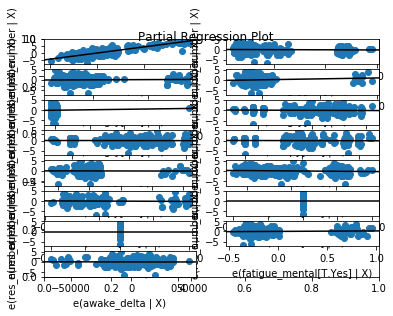

In [32]:
fig,plots  = plt.subplots(1,1)
fig = sm.graphics.plot_partregress_grid(model, fig=fig)